# Generative Pre-Trained Transformers

[Video](https://www.youtube.com/watch?v=kCc8FmEb1nY)<br>
[Repository](https://github.com/karpathy/ng-video-lecture)

Notebook by [mk2112](https://github.com/mk2112)

## Table of Contents
- [Outline](#outline)
- [Building the Dataset](#building-the-dataset)
- [Digression - Tiktoken](#digression---tiktoken)
- [Tokenizing the Dataset](#tokenizing-the-dataset)
- [Splitting the Dataset](#splitting-the-dataset)
    - [What can we actually train on?](#what-can-we-actually-train-on)
- [Embedding Layer](#embedding-layer)
- [Setting up a Loss Function](#setting-up-a-loss-function)
- [Producing The First Text](#producing-the-first-text)
- [The mathematical trick in self-attention](#the-mathematical-trick-in-self-attention)
    - [Tangent: Understanding the Softmax trick](#tangent-understanding-the-softmax-trick)
- [Building Self-Attention](#building-self-attention)
    - [Tangent: Residual Connections](#tangent-residual-connections)
    - [Tangent: Add and Norm](#tangent-add-and-norm)
- [Concolusion](#concolusion)
    - [ChatGPT?!](#chatgpt) 

ChatGPT is interesting. It sequentially generates text based on prompts. And it does so slightly differently every time.<br>Also, its prompt acceptance technically seems to not be limited by anything.<br>
ChatGPT is a probabilistic system, a language model.<br>
It continues a sequence started by our prompt by modeling a continuing sequence of words.

How does this work? What kind of model is applied under the hood?<br>
[Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) proposed the Transformer model architecture.<br>
Transformers really took over the field of AI by now...

## Outline

We will train a transformer-based, character-level language model on [Tiny-Shakespeare](https://raw.githubusercontent.com/jcjohnson/torch-rnn/master/data/tiny-shakespeare.txt) (all of Shakespeare in a single file).<br>
Put differently, we will re-implement [nanoGPT](https://github.com/karpathy/nanoGPT).

Given a chunk of text from Tiny Shakespeare, the transformer will decide on what character will follow.<br>
GPT is state-of-the-art (2022) in language modeling.

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken

## Building the Dataset

Let's first look at the contents of the dataset:

In [2]:
# Read the txt file to inspect it
with open('tiny-shakespeare.txt', 'r') as f:
    text = f.read()

print("Length of dataset:", len(text), "\n")
print(text[:100]) # First 100 characters

Length of dataset: 1115394 

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


We can find the unique characters by interpreting the entire text as a set of characters.<br>
This makes each character unique in the set.<br>
We go on to convert it to a list and sort it alphabetically.<br>
Counting this list's length gives us the number of unique characters in the dataset:

In [3]:
chars = sorted(list(set(text))) # Get all unique characters in the text
vocab_size = len(chars)         # Length of the vocabulary (this includes the space character)
print(''.join(chars))
print(f'\nVocabulary size: {vocab_size}')


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

Vocabulary size: 65


This set of characters makes up what our model will produce.<br>
Characters are hard to train on though.<br>
We will tokenize the characters by mapping them to integers.<br>

The integer represents the index of the character in the list `chars`.

In [4]:
# This is both encoder and decoder
stoi = { ch:i for i,ch in enumerate(chars) }     # Character to index mapping
itos = { i:ch for i,ch in enumerate(chars) }     # Index to character mapping
encode = lambda s: [stoi[c] for c in s]          # Encode a string to a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # Decode a list of integers to a string

msg = "hii there"
token_list = encode(msg)
print(token_list)
print(decode(token_list))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


## Digression - Tiktoken

Different systems use different approaches to encoding/decoding.<br>
For example, OpenAI uses byte-pair encoding (BPE) with their GPT-2 model.<br>
BPE is a subword tokenization technique. It is a bit more complex than what we will do here, but its shown here nonetheless for a little bit:

In [5]:
enc = tiktoken.get_encoding('gpt2')

msg = "hii there"
token_list = enc.encode(msg)
print(token_list) # BPE returns fewer tokens than the character encoding
print(enc.decode(enc.encode("hii there")))

print(enc.n_vocab) # total amount of tokens in the vocabulary

[71, 4178, 612]
hii there
50257


Tiktoken shows that there is a trade-off between the length of the encoding and the amount of tokens.<br>
We can have short sequences of tokens with very large vocabulary, or we can just as well have long sequences of tokens with a small vocabulary.

This BPE approach is used widely for NLP tasks nowadays.

## Tokenizing the Dataset

Let's now tokenize our Shakespeare dataset with our character-to-index mapping:

In [6]:
# Encode the text into a tensor of integers
data = torch.tensor(encode(text), dtype=torch.long)
print(f'Total size: {data.shape} elements of type {data.dtype}')
print('First 10 tokens from the dataset:', data[:10])

Total size: torch.Size([1115394]) elements of type torch.int64
First 10 tokens from the dataset: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])


## Splitting the Dataset

The entire Tiny-Shakespeare text is now represented as a sequence of integers.<br>
We can start separating the data into training and validation sets.

In [7]:
n = int(0.9 * len(data)) # 90% of the data will be used for training and 10% for validation
train_data = data[:n]    # 0 to 90-th percentile
val_data = data[n:]      # 90-th percentile to the end

Let's prepare the model. We will never feed our model the entire sequence of tokens as prompt at once.<br>
Instead, we will feed it **a randomly drawn but consecutive sequence of tokens**.<br>
The model will then predict the next token in the sequence from this prompt.<br>

> We call these consecutive, size-limited input sequences of tokens **blocks**.<br>
> Size-limited means that blocks can have a length of up to `block_size`.

In [8]:
block_size = 8              # Upper limit on the length of the text sequences
train_data[:block_size + 1] # First 9 characters (8 + 1 for the target)

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

### What can we actually train on?

If you zoom out, this block is just a sequence of 'correctly' aligned tokens.<br>
Given $[18, 47, 56, 57, 58, 1, 15, 47, 58]$, we have $8$ different trainable examples:<br>
- $[18] \rightarrow 47$
- $[18, 47] \rightarrow  56$
- $[18, 47, 56] \rightarrow 57$ etc.

Let's illustrate this with a small example:

In [9]:
# first block of tokens
x = train_data[:block_size]    # e.g. [1, 2, 3, 4, 5, 6, 7, 8]
# individual tokens shifted by one (also including the very last token now)
y = train_data[1:block_size+1] # e.g. [2, 3, 4, 5, 6, 7, 8, 9]

for t in range(block_size):
    context = x[:t+1] # context means the prompt
    target = y[t]     # the token we want to predict
    print(f'When the prompt is {context}, predict {target}')

When the prompt is tensor([18]), predict 47
When the prompt is tensor([18, 47]), predict 56
When the prompt is tensor([18, 47, 56]), predict 57
When the prompt is tensor([18, 47, 56, 57]), predict 58
When the prompt is tensor([18, 47, 56, 57, 58]), predict 1
When the prompt is tensor([18, 47, 56, 57, 58,  1]), predict 15
When the prompt is tensor([18, 47, 56, 57, 58,  1, 15]), predict 47
When the prompt is tensor([18, 47, 56, 57, 58,  1, 15, 47]), predict 58


We have context sizes $1$ to $8$.<br>

> Training on each of the possible contect sizes makes the model more robust to differently sized inputs.

For prompts **above** `block_size`, we will start truncating the prompt to `block_size` or less sized prompts.

In theory, we could train on a single sequence at a time. We could input this sequence into the model, get the prediction, and then update the model's parameters.<br>
However, from the vast set of possible sequences it becomes clear that this is **not very efficient**.

For more efficient GPU usage, we will train on multiple sequences (each of *exactly* size `block_size`) at once. This is called **mini-batching**.

In [10]:
torch.manual_seed(1337)
batch_size = 4  # number of sequences in a batch / processed in parallel
block_size = 8  # maximum length of the sequence serving as a prompt/context

In [11]:
def get_batch(split, batch_size):
    # Generate a batch of inputs/prompts x and respective targets y
    # batches are always of shape (batch_size, block_size)
    data = train_data if split == 'train' else val_data
    # Tensor of shape (batch_size,) with random sequence start indices between 0 and len(data) - block_size
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # Accumulate and add each sequence of this batch to form a tensor
    x = torch.stack([data[i:i+block_size] for i in ix])
    # Same as x but shifted by one token
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y # x is (4,8), y is (4,8) too

# Get a batch of inputs and targets
xb, yb = get_batch('train', batch_size)

# Print the shape of the batch and the actual data
print('inputs shape: ', xb.shape)
print(xb,'\n')
print('targets shape: ', yb.shape)
print(yb, '\n')

# Print the first batch
for b in range(batch_size):     # batch dimension, number of sequences in the batch (batch_size)
    for t in range(block_size): # time dimension, number of tokens in the sequence  (block_size)
        context = xb[b, :t+1]   # context means prompt, taking the first t+1 tokens from the b-th sequence in the batch
        target = yb[b, t]       # we take the t-th token from the b-th sequence in the batch for the target (the token we want to predict)
        print(f'When the prompt is {context}, predict {target}')
        # This context <-> target pair is what we feed to the model, it's variable in length

inputs shape:  torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]]) 

targets shape:  torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]]) 

When the prompt is tensor([24]), predict 43
When the prompt is tensor([24, 43]), predict 58
When the prompt is tensor([24, 43, 58]), predict 5
When the prompt is tensor([24, 43, 58,  5]), predict 57
When the prompt is tensor([24, 43, 58,  5, 57]), predict 1
When the prompt is tensor([24, 43, 58,  5, 57,  1]), predict 46
When the prompt is tensor([24, 43, 58,  5, 57,  1, 46]), predict 43
When the prompt is tensor([24, 43, 58,  5, 57,  1, 46, 43]), predict 39
When the prompt is tensor([44]), predict 53
When the prompt is tensor([44, 53]), predict 56
When the prompt is tensor([44, 53, 

## Embedding Layer

An input batch consists of tensors `xb` and `yb`.<br>
Both `xb` and `yb` are of size $batch\_size \times block\_size$.

The batch is used as basis for 'sub-batching'.

Because `yb` is just `xb` shifted by one token, we can use `yb` to train<br>
on multiple examples *within a batches' partial sequences*, each being of different context size.

These 'sub-batches' are called `context` and `target`. They are the pairs that we will feed into the model.

For now, we can start focusing on the model itself and feed `xb` and later on `yb` into it.<br>
We'll start building a bigram model, like before in the Makemore series.

This is a model that predicts the next token based on the previous token:

In [12]:
torch.manual_seed(1337) # for reproducibility

# Not really an LM at this stage, but we will get there...
class BigramLM(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # Embedding the vocabulary
        # Every one of the vocab_size tokens is represented by a vector of size vocab_size
        self.embed = nn.Embedding(vocab_size, vocab_size) # 65 unique 65-dim vectors

    def forward(self, idx, targets):
        # idx is of shape (batch_size, block_size)
        # targets is of shape (batch_size, block_size)
        # Embed the input indices, shape is now (batch_size, block_size, vocab_size) (B, T, C)
        logits = self.embed(idx)
        return logits


print('Vocabulary size:', vocab_size)  # Length of the vocabulary list (this includes the space character)
m = BigramLM(vocab_size)  # Instantiate the model
out = m(xb, yb)           # Forward pass (yb remains unused for now)
print(out.shape)          # (batch_size, block_size, vocab_size) -> 4 times 8 characters, each embedded as a 65-dim vector

Vocabulary size: 65
torch.Size([4, 8, 65])


Every integer of our tokenized text is now represented by an embedding vector of size `vocab_size`.<br>
We do this by using an embedding layer. This layer is effectively a lookup table that maps<br>
each possible (`vocab_size` are possible in total) character-representing index to a unique vector of size `vocab_size`.

The `logits` are the outputs of the model.<br>
We just treat the embedded tokens of the input batch as the logits.<br>
This `logits` tensor holds all the embedded identities of the tokens in the input batch -> ($batch\_size \times block\_size \times vocab\_size$).

We are *not yet* interconnecting the tokens with any sort of model/logic.<br>
We are not yet training or predicting *anything*.

This is about to change.

## Setting up a Loss Function

In [13]:
torch.manual_seed(1337)

class BigramLM(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, vocab_size)  # Embedding the vocabulary, each individual token is represented by a vector of size vocab_size

    def forward(self, idx, targets):
        logits = self.embed(idx)      # Embed the input indices, shape is now (batch_size, block_size, vocab_size) (B, T, C)
        B, T, C = logits.shape        # B = batch_size, T = block_size, C = vocab_size
        logits = logits.view(B*T, C)  # Transpose logits to (B*T, C)
        # This is the first time we actively use the targets:
        targets = targets.view(B*T)   # Transpose targets to (B*T) (targets contains the next token's index for each input sequence in the batch)
        loss = F.cross_entropy(logits, targets)  # Calculating cross entropy loss across all tokens in the batch (using targets to plug out the correct token for each input sequence)
        return logits, loss


m = BigramLM(vocab_size)  # Instantiate the model
logits, loss = m(xb, yb)  # Forward pass (xb becomes embedded, yb is used to calculate the loss)
print(logits.shape)       # (batch_size * block_size, vocab_size)
print(loss.item())        # Loss value

torch.Size([32, 65])
4.878634929656982


Given that we have the identities of the next character through `yb`, how well does the model predict them through the `logits`? The `loss` is the measurement of prediction quality.

We want the index within `yb` to be the same as the most likely/active index within `logits`.<br>
The loss is measured as the average of this across all the tokens in the input batch.

We know the `vocab_size` is $65$.<br>
We can calculate what the loss should be if we were to predict the next token totally randomly:

$$-ln(\frac{1}{65}) = 4.1743872699$$

Our calculated loss is **higher/worse**, because we are not predicting perfectly randomly to begin with.<br>
The initial predictions are not perfectly spread out across the `vocab_size`.<br>
They aren't super diffuse and contain a bit of entropy.<br>
We haven't yet learned uniform distribution across the `vocab_size`.

![](https://images.squarespace-cdn.com/content/56316c94e4b098620a45e78a/1457973972468-D5XJVA1ABFXSD0AH9RZC/?content-type=image%2Fpng)
<br>Source: [Shiken](https://shiken.ai/chemistry/entropy)

The `loss` is to be minimized.<br>
We will need the model to make predictions of individual next tokens.<br>

Let's append the current model with a function `generate` that takes in the last token of a sequence and returns the next token however many times we want:

In [14]:
torch.manual_seed(1337)

class BigramLM(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, vocab_size)      # Embedding the vocabulary, each individual token is represented by a vector of size vocab_size

    def forward(self, idx, targets=None):
        logits = self.embed(idx)                               # Embed the input indices, shape is now (batch_size, block_size, vocab_size) (B, T, C)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)                       # Transpose logits to (B, C, T) (B=batch_size, T=block_size, C=vocab_size)
            targets = targets.view(B*T)                        # Transpose targets to (B, T)
            loss = F.cross_entropy(logits, targets)            # Calculating cross entropy loss across all tokens in the batch
        return logits, loss

    # Generate new tokens based on respective last token of a sequence
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, _ = self(idx)                              # Forward pass (this is the forward function) with the current sequence of characters idx, results in (B, T, C)
            logits = logits[:, -1, :]                          # Focus on the last token from the logits (B, T, C) -> (B, C)
            probs = F.softmax(logits, dim=-1)                  # Calculate the probability distribution for the next token based on this last token, results in (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # Sample the next token (B, 1), the token with the highest probability is sampled most likely
            idx = torch.cat((idx, idx_next), dim=1)            # Add the new token to the sequence (B, T+1) for the next iteration
        return idx                                             # Return the sequence of tokens (B, T+1), these are characters

m = BigramLM(vocab_size)  # Instantiate the model
logits, loss = m(xb, yb)  # Forward pass

print(logits.shape)       # (batch_size, block_size, vocab_size)
print(loss) # Loss value

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


Let's recap this `generate` function:<br>
The function takes in a batch of tokens `xb` and a number of tokens to generate `n`. 

Repeated over `n` times, it will:
- forward pass through the model with tokens `xb` to get `logits`
- disregard everything but the last token of `xb`
- calculate the probability of each possible token in the vocabulary to be the token after this last `xb` token; this is done with `F.softmax`
- sample a token from the probability distribution with `torch.multinomial`, this returns an index of the token that we can use to look up the token itself in the vocabulary if we wanted
- append the sampled token to the tokens `xb`
- repeat

See that `self(idx)` calls the `forward` function of the model. `forward` is adapted accordingly above to also take a call with just `idx`.

Let's run this model.

## Producing The First Text

In [15]:
ix = torch.zeros((1, 1), dtype=torch.long)  # Start with a single tensor of shape (1, 1) holding a 0 (new line)
tokens = m.generate(ix, max_new_tokens=100) # Generate 100 tokens as a sequence of indices
print(tokens.shape)                         # Print the shape of the resulting sequence of tokens
print(decode(tokens[0].tolist()))           # Decode the resulting sequence of indices to a string

torch.Size([1, 101])

SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


We do the most basic generative task here:<br>
We feed the model a prompt of just the newline character and let it iteratively<br>
generate 100 'most probable' characters as a follow-up.<br>

Within the print-statement there is the `[0]` call. This is **not** because we are only interested in a first character of the generated text or anything like that.<br>
It is because `generate` returns a tensor of size `batch_size x 101`. We only have a `batch_size` of $1$ here, so we can just take the first element of the array and convert it to a string.


The generation as is right now is not very good.<br>
The `generate` function loops, increases the `context_size` and always re-feeds itself with this growing context.<br>
Yet, with the logits generated from that we are not taking anything beyond/prior the logits of the last token from the context as basis for our prediction.

For the current approach, our context could be of fixed size. With the current (bigram) model, we are not using the context to its full potential. This will be addressed soon.

For now, let's train!

In [16]:
# Create a PyTorch Optimizer
# Instantiate AdamW optimizer with the model parameters (weights) 
# and a learning rate of 0.001 (often used value for *small* networks)
opt = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [17]:
batch_size = 32 # Increasing the batch size from 4 to 32
losses = []

# Train for 10000 steps/batches
for steps in range(10000):
    xb, yb = get_batch('train', batch_size) # Sample a batch of data
    logits, loss = m(xb, yb)                # Forward pass, calculate the loss
    loss.backward()                         # Backprop with PyTorch's autograd 
                                            # (effectively just updating the logits/the embedding vectors)
    opt.step()                              # Update the weights
    opt.zero_grad()                         # Set the gradients to zero

    # Print the loss every 100 steps
    if steps % 100 == 0:
        print(f'Loss at step {steps}: {loss.item()}')
        losses.append(loss.item())

Loss at step 0: 4.692410945892334
Loss at step 100: 4.621085166931152
Loss at step 200: 4.549462795257568
Loss at step 300: 4.345612049102783
Loss at step 400: 4.25573205947876
Loss at step 500: 4.214480876922607
Loss at step 600: 4.124096870422363
Loss at step 700: 3.9863951206207275
Loss at step 800: 3.9517807960510254
Loss at step 900: 3.837888717651367
Loss at step 1000: 3.7637593746185303
Loss at step 1100: 3.6824679374694824
Loss at step 1200: 3.533822536468506
Loss at step 1300: 3.513597011566162
Loss at step 1400: 3.4971799850463867
Loss at step 1500: 3.3378093242645264
Loss at step 1600: 3.3668529987335205
Loss at step 1700: 3.2826082706451416
Loss at step 1800: 3.1327052116394043
Loss at step 1900: 3.160909652709961
Loss at step 2000: 3.2342259883880615
Loss at step 2100: 2.9978363513946533
Loss at step 2200: 3.094273090362549
Loss at step 2300: 2.9780406951904297
Loss at step 2400: 2.890953302383423
Loss at step 2500: 2.9391205310821533
Loss at step 2600: 2.8254294395446777


Let's now sample from the model and see how it performs:

In [18]:
print(decode(m.generate(torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


lso br. ave aviasurf my, yxMPZI ivee iuedrd whar ksth y h bora s be hese, woweee; the! KI 'de, ulseecherd d o blllando;LUCEO, oraingofof win!
RIfans picspeserer hee tha,
TOFonk? me ain ckntoty ded. bo'llll st ta d:
ELIS me hurf lal y, ma dus pe athouo
BEY:! Indy; by s afreanoo adicererupa anse tecorro llaus a!
OLeneerithesinthengove fal amas trr
TI ar I t, mes, n IUSt my w, fredeeyove
THek' merer, dd
We ntem lud engitheso; cer ize helorowaginte the?
Thak orblyoruldvicee chot, p,
Bealivolde Th li


We currently exclusively embed the tokens into randomly generated 65-dimensional vectors.<br>
When we then enter a batch of $4$ token sequences, where each sequence is $8$ character indices long.<br>
We embed the indices to receive a tensor of size $[4 \times 8 \times 65]$.<br>
We then reshape this tensor to $[32 \times 65]$ and compare that with the target tensor of (also reshaped) size $32$.<br>
The loss is then the determined by the `CrossEntropyLoss` function, which effectively plugs out the probability of the target token from the `logits` with index of the target token and then takes the negative logarithm of that.<br>
The loss is then averaged across all the tokens in the batch. A scalar value is returned.

We build a model that optimizes the embedding vectors to carry the highest probabilities for the most likely next token(s).

Remember, we only increased `batch_size` and trained for more epochs.<br>
The model is still the same. We still only predict the next token based on the previous token.

**There is one thing to say about the loss:**<br>
At this point, the loss is very noisy. This is due to every batch being (independently) more or less lucky with predictions.<br>
Viewed across the entire training, the loss is not really comparable across batches, making the loss jumpy.

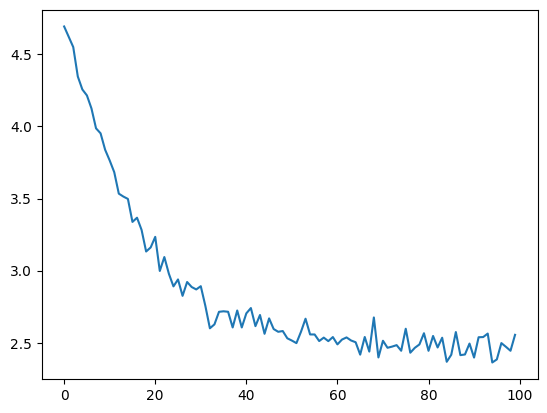

In [19]:
from matplotlib import pyplot as plt
plt.plot(losses);

Consider that this is sampled loss after every $100$ steps.<br>
The loss we visualize here is too batch-specific and each batch is too small to be representative of the entire training.<br>
We see a trend though. At this point, switch over to `bigram.py` to see our code in execution-optimized script form.<br>
There, this loss interpretation problem is addressed like so:

In [20]:
eval_iters = 200
max_iters = 10000
eval_interval = 500

@torch.no_grad() # Disable gradient calculation for this function
def evaluate_loss():
    out = {}
    m.eval() # Set model to evaluation mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, batch_size)
            _, loss = m(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train() # Set model back to training mode
    return out

train_losses = []

# Training
for iter in range(max_iters):
    xb, yb = get_batch('train', batch_size) # Get batch
    logits, loss = m(xb, yb)                # Forward pass
    loss.backward()                         # Backward pass
    opt.step()                        # Update parameters
    opt.zero_grad(set_to_none=True)   # Reset gradients

    if iter % eval_interval == 0:
        losses = evaluate_loss()
        train_losses.append(losses["train"].item())
        print(f'Iter {iter:4d} | Train Loss {losses["train"]:6.4f} | Val Loss {losses["val"]:6.4f}')

# Generate text from the model
context = torch.zeros((1, 1), dtype=torch.long) # Start with a zero context
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

Iter    0 | Train Loss 2.4653 | Val Loss 2.4886
Iter  500 | Train Loss 2.4742 | Val Loss 2.4727
Iter 1000 | Train Loss 2.4654 | Val Loss 2.4810
Iter 1500 | Train Loss 2.4587 | Val Loss 2.4703
Iter 2000 | Train Loss 2.4539 | Val Loss 2.4912
Iter 2500 | Train Loss 2.4517 | Val Loss 2.4801
Iter 3000 | Train Loss 2.4634 | Val Loss 2.4788
Iter 3500 | Train Loss 2.4557 | Val Loss 2.4851
Iter 4000 | Train Loss 2.4622 | Val Loss 2.4873
Iter 4500 | Train Loss 2.4475 | Val Loss 2.4838
Iter 5000 | Train Loss 2.4483 | Val Loss 2.4757
Iter 5500 | Train Loss 2.4622 | Val Loss 2.4837
Iter 6000 | Train Loss 2.4517 | Val Loss 2.4863
Iter 6500 | Train Loss 2.4567 | Val Loss 2.4837
Iter 7000 | Train Loss 2.4525 | Val Loss 2.4908
Iter 7500 | Train Loss 2.4663 | Val Loss 2.4820
Iter 8000 | Train Loss 2.4542 | Val Loss 2.4769
Iter 8500 | Train Loss 2.4480 | Val Loss 2.4832
Iter 9000 | Train Loss 2.4602 | Val Loss 2.4832
Iter 9500 | Train Loss 2.4514 | Val Loss 2.4857

Risaveld s,

NGES t y s;
IUKI e ysinse 

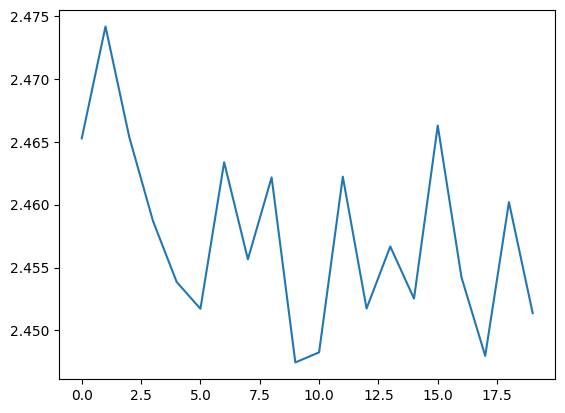

In [21]:
plt.plot(train_losses);

Instead of just printing the loss batch-wise, `evaluate_loss` averages the loss across `eval_iter` batches.<br>
For `eval_iter` times, `evaluate_loss` will sample a batch of tokens, run the current model on it and average the loss.

This is done for both the training and validation set.

It is more accurate to do this, because now we start to see the trend of the loss in context of multiple, randomly sampled batches and thus a broader representation of the dataset.<br>
As the loss is averaged over multiple batches, it is also less noisy.

With all of this, our `bigram.py` script is a great starter for bulding a GPT.

## The mathematical trick in self-attention

We are *almost* ready to start implementing a self-attention block.<br>
There is one thing that we need to understand first: **The trick in Self-attention**.<br>
It will look confusing at first, but it is actually *very* simple.

Let's dive in. Consider the following example, where the `vocab_size` is just $2$:

In [22]:
torch.manual_seed(1337)  # Set seed for reproducibility
B, T, C = 4, 8, 2        # Batch size, block size, vocab size
x = torch.randn(B, T, C) # Random numbers form a tensor of shape (B, T, C)

Here we have $8$ tokens, each of which is a vector of size $2$.<br>
They are not talking to each other / are not related to each other in any way.

We'd like to couple them so that e.g. the 3rd token can only communicate with the tokens in the 2nd and 1st location, but **not** with a future token in the 4th location.

> **Information has to be able to flow, but exclusively in one direction.**

We can do this in a most simple way by averaging preceding tokens, including the `current_token`.<br>
This would, in essence, summarize `current_token` in the context of `current_token`'s history.

For every $t$-th token, we'd like to get the average of all the vectors of previous tokens and the current one ($t$) as well:

In [23]:
# We want x[b, t] = mean_{i <= t} x[b, i]
xbow = torch.zeros((B, T, C))          # Create tensor of zeros of shape (B, T, C) (bag of words representation of the input)
for b in range(B):                     # For all batches
    for t in range(T):                 # For all tokens in the batch
        xprev = x[b, :t+1]             # Get all tokens up to and including the current token (t, C)
        xbow[b, t] = xprev.mean(dim=0) # Calculate the mean of the tokens up to and including the current token

print('Batch [0]:\n', x[0], "\n")     # First batch of 8 tokens, each of size 2
print('Running Averages:\n', xbow[0]) # Running averages of the first batch of 8 tokens, each of size 2

Batch [0]:
 tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]]) 

Running Averages:
 tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


Due to the loops, this is relatively inefficient.<br>**The trick is that we can build a running average like this using<br>
much faster matrix multiplication:**

In [24]:
# Consider the following example

torch.manual_seed(42)
a = torch.ones(3, 3)                        # 3x3 matrix of ones
b = torch.randint(0, 10, (3, 2)).float()    # 3x2 matrix of random integers between 0 and 9
c = a @ b                                   # Matrix multiplication of a and b
print(f'a (ones) =\n{a}\n')
print(f'b (random) =\n{b}\n')
print(f'c = a @ b =\n{c}\n')

a (ones) =
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

b (random) =
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])

c = a @ b =
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])



Just a recap on what's going on behind the scenes:
<center><img src="https://www.mscroggs.co.uk/img/full/multiply_matrices.gif"/></center>

Now, consider the torch function `torch.tril`.<br>
It returns the lower triangular part of a matrix (2D tensor).<br>
Applying `torch.tril` to matrix `a` will calculate the running column-wise sum of `a`:

In [25]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))            # Lower triangular matrix of ones (tril used here)
b = torch.randint(0, 10, (3, 2)).float()    # 3x2 matrix of random integers between 0 and 9
c = a @ b                                   # Matrix multiplication of a and b

print(f'a (ones + tril) =\n{a}\n')
print(f'b (random) =\n{b}\n')
print(f'c = a @ b =\n{c}\n')

a (ones + tril) =
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

b (random) =
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])

c = a @ b =
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])



If we now normalize the `torch.tril`'ed matrix `a` by dividing by the number of tokens in the batch, we get the running average of `a`:

In [26]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))   # Lower triangular matrix of ones
a = a / a.sum(dim=1, keepdim=True) # Normalize the matrix by dividing along each row
b = torch.randint(0, 10, (3, 2)).float() # 3x2 matrix of random integers between 0 and 9
c = a @ b                                # Matrix multiplication of a and b

print(f'a (ones + tril + avg) =\n{a}\n')
print(f'b (random) =\n{b}\n')
print(f'c = a @ b =\n{c}\n')

a (ones + tril + avg) =
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

b (random) =
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])

c = a @ b =
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])



Transfered to our context, this means that we can calculate the running average of the tokens in the batch<br>
by multiplying the batch with the `torch.tril`'ed matrix `a`:

In [27]:
#Goal: We want x[b, t] to be mean_{i <= t} for x[b, i]
B, T, C = 4, 8, 2        # Batch size, block size, vocab size
x = torch.randn(B, T, C) # Random input of shape (B, T, C)

# Old:
xbow = torch.zeros((B, T, C))          # Create tensor of zeros of shape (B, T, C) (bag of words representation of the input)
for b in range(B):                     # For all batches
    for t in range(T):                 # For all tokens in the batch
        xprev = x[b, :t+1]             # Get all tokens up to and including the current token (t, C)
        xbow[b, t] = xprev.mean(dim=0) # Calculate the mean of the tokens up to and including the current token

# New:
wei = torch.tril(torch.ones(T, T))       # Lower triangular matrix of ones
wei = wei / wei.sum(dim=1, keepdim=True) # Normalizing wei by dividing by the sum of each row
xbow2 = wei @ x # (T, T) @ (B, T, C) -> PyTorch's Auto-Stride -> (B, T, T) @ (B, T, C) = (B, T, C)

torch.allclose(xbow, xbow2) # True

True

The matrix multiplication step in this implementation indirectly uses<br>
PyTorch's ability to 'bolster' the matrix `wei` to the dimensionailty of the batch `x`.<br>
Beacause of that, we effectively apply the same matrix `wei` for every batch `B` in the dataset.<br>
And this enables us to build a running average of the entire batch **in one go**.

Think of `wei` as being a mask of `(block_size, block_size)` or `(characters_per_input, characters_per_input)`.<br>
Now, in parallel, we apply `wei` to each and every batch entry.<br>
And due to PyTorch replicating `wei` along the batch-dimension, in one take, we get the running average of the entire batch.<br>
**That's the trick**.

With that out of the way, we can now add softmax to the matrix multiplication step, stepping closer to the self-attention block:

In [28]:
# New:
wei = torch.tril(torch.ones(T, T))       # Lower triangular matrix of ones
wei = wei / wei.sum(dim=1, keepdim=True) # Normalizing wei by dividing by the sum of each row
xbow2 = wei @ x                          # (T, T) @ (B, T, C) -> (B, T, T) @ (B, T, C) = (B, T, C)

# Newer:
tril = torch.tril(torch.ones(T, T))             # Lower triangular matrix of ones

wei = torch.zeros((T, T))                       # (T, T)
wei = wei.masked_fill(tril == 0, float('-inf')) # Masking all values in wei where tril == 0 with -inf
wei = F.softmax(wei, dim=-1)                    # (T, T)

xbow3 = wei @ x                                 # (T, T) @ (B, T, C) -> (B, T, T) @ (B, T, C) = (B, T, C)

torch.allclose(xbow2, xbow3)                     # True

True

### Tangent: Understanding the Softmax trick

Let's take a look at the softmax function. Up until now, we have made some steps before we apply softmax to the matrix multiplication step:

- Create a tril matrix `tril` of ones with dimensions `(T, T)` where `T = block_size`
- Create a matrix `wei` of all zeros with dimensions (T, T)
- For every entry in `tril` that is 0: Set the corresponding entry in `wei` to `-inf`

We now apply softmax row-wise to `wei`, which does the following:

In [29]:
exwei = torch.tensor([[0, 0, float('-inf'), float('-inf'), float('-inf'), float('-inf'), float('-inf')], 
                      [0, 0, 0, float('-inf'), float('-inf'), float('-inf'), float('-inf')]])
exsof = F.softmax(exwei, dim=-1) # -1 means the last dimension
print(exsof)

tensor([[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000]])


**Why is softmax behaving like this?**<br>

$$softmax(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}}$$

```python
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)
```

From a row-wise perspective, `wei` holds a bunch of values that we want to turn into probabilities - our probability mask `wei` as we know it.<br>
Enter softmax. Row-wise, it squashes all values down into a probability distribution. It does this by raising each value to the power of $e$, then dividing that by the sum of all the values of the row raised to the power of $e$. This normalizes the values so that they all add up to $1$. We created a probability distribution.

Now, the entries of `wei` that are not in the lower triangular part are $-inf$.<br>
This means that softmax will set the probability of these entries to be most unlikely / $0$.<br>
With the rest of the entries being all the same ($0$), softmax will distribute the total probability of $1$ across the remaining entries.

This suggests that we get the masking effect that we want with `wei`. This is indeed the case:

In [30]:
tril = torch.tril(torch.ones(T, T))             # Lower triangular matrix of ones
wei = torch.zeros((T, T))                       # (T, T)
wei = wei.masked_fill(tril == 0, float('-inf')) # Masking all values in wei where tril == 0 with -inf
wei = F.softmax(wei, dim=-1)                    # (T, T)
xbow3 = wei @ x                                 # (T, T) @ (B, T, C) -> (B, T, T) @ (B, T, C) = (B, T, C)

print(wei[0:3])

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


Zooming out, this softmax trick is very illustrating.<br>
Effectively, `wei.masked_fill(tril == 0, float('-inf'))` states that tokens from the *future* should be disregarded in the attention calculation.<br>

**Spoiler:** The probabilities left in `wei` are the attention weights or *affinities*. They will be trained.

**Key Takeaway** is still that we can now do weighted aggregation of the past tokens by using matrix multiplication with `tril`, where the lower elements will tell how much a past or current token should be influencing the choice of the next token. Let's restructure the model for this in `gpt.py`.

**Changelogs compared to `bigram.py`:**

- `__init__` now takes no arguments (`vocab_size` is now a global variable)
- Intermediate phase added before logit embedding:
    - Changed embedding layer dimensions from `(vocab_size, vocab_size)` to `(vocab_size, n_embd)`
        - `n_embd` is the now arbitrary size of the vector into which the token is embedded
    - Added a linear layer for the logit embedding of dimensions `(n_embd, vocab_size)` so that we can do the weighted aggregation of the past tokens with size `(n_embd, n_embd)`
- Added positional embeddings
    - `position_embd` is an Embedding Layer of dimensions `(vocab_size, n_embd)`, embeds the token position in the sequence
    - `pos_embd` is the positional embedding of the current token, which is added (+) to the embedding of the current token information
    - this sum is then passed to the linear layer for the logit embedding

These changes do *not yet* affect anything, because we are still missing the self-attention block and still run the trusty bigram model. But the model works still.

## Building Self-Attention

We build a self-attention block for a single, individual head for simplicity.<br>
To do that, we'll continue with our 'running average' trick from before. I already hinted at it: We don't want the probabilities of `wei` to be row-wise uniform.<br>
Different tokens should find different other tokens more or less important/interesting. **And [this](https://www.youtube.com/watch?v=ZoHfX_Os344) should be learned by the model.**

> Gather information from the past, but do so in a data-dependent way and improve based on training.

With Self-Attention, every single token in the batch emits two vectors: `query` and `key`:
- The **`query` vector** is the token-specific "What am I looking for?" information
- The **`key` vector** is the token-specific "What do I contain?" information

To establish **affinity** (high interrelation and high influence on the sampling decision) between tokens of the batch, 
we calculate the dot product of the `query` and `key` vectors of each token with each other token in the batch.<br>
**This is the `affinity` matrix or in our case `wei`.**

If during dot product calculateion the `key` and the `query` turn out to be well aligned or similar, the affinity will be high. If they are not, the affinity will be low.

Let's build the individual head:

In [31]:
# Version 4: Self-Attention
torch.manual_seed(1337)

B, T, C = 4, 8, 32        # Batch size, block size, vocab size (each token is a vector of size 32)
x = torch.randn(B, T, C)  # Random input of shape (B, T, C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)   # No bias so that solely fixed weight matrix multiplication is performed
query = nn.Linear(C, head_size, bias=False) # No bias so that solely fixed weight matrix multiplication is performed
value = nn.Linear(C, head_size, bias=False) # No bias so that solely fixed weight matrix multiplication is performed

k = key(x)   # (B, T, C) -> (B, T, head_size)
q = query(x) # (B, T, C) -> (B, T, head_size)

wei = q @ k.transpose(-2, -1)  # (B, T, head_size) @ (B, head_size, T) = (B, T, T) (T is the block_size)

tril = torch.tril(torch.ones(T, T))             # Lower triangular matrix of ones
#wei = torch.zeros((T, T))                      # (T, T)
wei = wei.masked_fill(tril == 0, float('-inf')) # Masking all values in wei where tril == 0 with -inf
wei = F.softmax(wei, dim=-1)                    # (T, T)
#out = wei @ x  # (T, T) @ (B, T, C) -> (B, T, T) @ (B, T, C) = (B, T, C)

v = value(x)   # (B, T, C) -> (B, T, head_size)
out = wei @ v  # (B, T, T) @ (B, T, head_size) = (B, T, head_size)

print(wei[0])

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)


When we `forward()` the Linear layers `key` and `query` by passing in the `x` batch, we get per `C` in `x = (B, T, C)` the trained `query` vector and `key` vector.<br>
Thus, applying `x` to the linear layers gets us `query` and `key` *at once* for each token in each block of each batch.<br>
This is why `k` and `q` are both `(B, T, head_size)`. Note that producing `query` and `key` vectors happens still independently for all tokens in the batch.

The communication happens through calculating the `affinity` matrix `wei`.<br>
We take the dot product of the `query` and `key` vectors of each token with each other token in the batch. To do so, we transpose `k` to `(B, head_size, T)` first and get `wei` of dimensions `(B, T, T)`.<br>
For every row of `B`, we have a $T \times T$ `(block_size x block_size)` matrix of affinities between all tokens in the batch. 

Because of $T$ as height- and width-dimension, we can use the softmax trick like before to mask out future tokens. The thing is, we now *don't* start out with a `wei` of all zeros, but with learnable affinities already in place.
Softmax thus will not distribute the probability of $1$ evenly across all tokens, but will distribute it based on the learnable affinities that we already have in place. **That's the whole point of self-attention.**

Let's view the `wei` value at the eighth token in the first batch.<br>
It is $0.2391$. The eighth token knows what its content is and what position it is in. Based on that, it creates a `query`.<br>

The `query` vector of the eighth token is:<br>
"I'm looking for consonants that are at max four positions away from me."

The `key` vector of the eighth token is:<br>
"I'm a vowel in the eigth position, I am a bunch of information about this vowel in the eighth position, a business card if you will."

The `key` vector of the fifth token is:<br>
"I'm a consonant in the fifth position, I am a business card with a bunch of information about this consonant in the fifth position."

With this information, the eighth token can calculate the affinity with the fifth token. It does so by taking the dot product of its `query` and the fifth token's `key`.<br>
This dot product will be high, because the `query` and `key` are well aligned. With high affinity, the fifth token becomes more likely to be chosen as the next token.

Ok, now let's address the value `v`.<br>
`v` is the value vector of the token. It is the token-specific "What can I communicate to you?" information.
- `q(x)`: Your job search criteria.
- `k(x)`: Your CV.
- `v(x)`: Your matching job offers.
- `x`: You, secretly hating 9-5.

Notice that we now only interact with `x` indirectly through `k` and `q`. Therefore we could say:
- `x` is the "Who am I talking to?" information


<center><img src="https://www.techiedelight.com/wp-content/uploads/Eulerian-path-for-directed-graphs.png"/></center>

- Attention is a **communication mechanism**. It can be seen as nodes in a directed graph looking at each other, aggregating their information via a weighted sum from all nodes pointing to them, with data-dependent weights.
    - With our graph, we have 8 nodes/tokens. The first nodes is pointed to by itself only. The second node is pointed to by the first node and itself and so on.
- There is **no notion of space** as attention just acts over a set of vectors. This is why we need to positionally encode tokens so that the model can learn to attend to tokens in a certain order.
- Each example across batch dimension is of course processed completely independently and never "talks" to other examples in the batch.
- Our block (see above) is called a "decoder" attention block because it has triangular masking. This is usually applied in autoregressive settings, like language modeling.
    - In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. 
- "self-attention" just means that the keys and values are produced from the same source as queries ($x$ in our case) 
    - In "cross-attention", the queries still get produced from $x$, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input `Q`,`K` are unit variance, `wei` will be unit variance too and Softmax will stay diffuse and not saturate too much.<br> 
  Illustration below:

In [32]:
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1) * (head_size ** -0.5) # This is the scaled attention, avoiding exploding variance which would sharpen the softmax distributions (and thus make the attention more deterministic)

print(k.var().item().__format__('.4f'))   # The variance is like before
print(q.var().item().__format__('.4f'))   # The variance is like before
print(wei.var().item().__format__('.4f')) # The variance is now much smaller

1.0449
1.0700
1.0918


We now take this self-attention concept for a spin in `gpt.py`.

**Changelog:**
- Defined and added a `Head` module to the model that contains the `query`, `key` and `value` linear layers and the `affinity` matrix calculation.
- Added multiple `Head`s in parallel to the model.
- Added `FeedForward` module to the model that contains the `intermediate` and `output` linear layers.
    - We had the multi-head attention module before, but calculating the logits happend too early. We now have a `FeedForward` module that takes the output of the multi-head attention module and calculates the logits. This is better, because `FeedForward` enables the tokens to think on what they have seen from the multi-head attention module.
    - Applying `FeedForward` further reduces loss and improves perplexity.
- Added `Block` module to the model that contains the `Head` and `FeedForward` modules and can be stacked $N$ times like in "Attention is all you need": 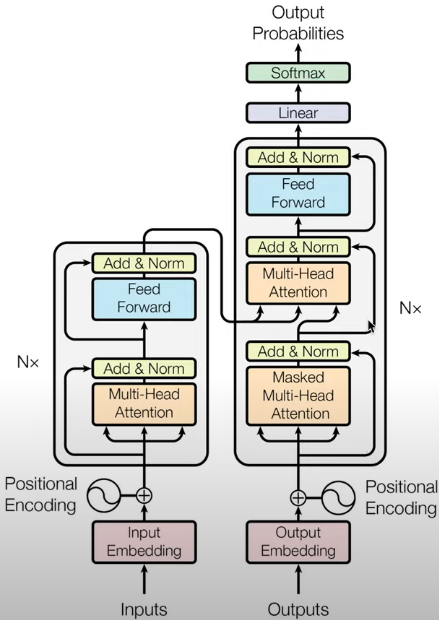

### Tangent: Residual Connections

Deep and very deep neural networks are hard to train. They suffer from optimization issues like vanishing and exploding gradients. Residual connections help with that.<br>
They are applied in "Attention is all you need" and we will apply them here too. Originally, the idea of residual connections was introduced in "Deep Residual Learning for Image Recognition".

It basically goes like this:<br>
You may transform the data through weight layers, but then you add the original data values onto the now transformed data values. To an extend, you are now free to fork off the residual pathway and apply the transformation to it. You don't have to, you can steer the intensity of the residual connection with a learnable parameter. This is called a "skip connection".

The reason this structure addresses the training problem is that addition is a linear operation. Addition distributes gradients equally across all inputs.<br>The gradients from the loss basically 'hop' from the output to the input while remaining more effective. Also they propagate into the residual pathway, which is a good thing.

>[!Note]
> With residual connections, you basically have a gradient superhighway, from supervision to input. Unimpeded by the weight layers in between.
> The residual blocks initially contribute very little to the residual pathway. During optimization, the residual blocks learn to contribute more and more to the residual pathway.


### Tangent: Add and Norm

In the image above, there is this "Add & Norm" part. The "Add" is the residual connection. See above.<br>
The "Norm" is a normalization layer of type `LayerNorm`. Yes, this is very close to what we discussed in Makemore 3. 

> [!Note]
> Batch Normalization made sure that the data is normalized across the **batch dimension**. Any individual neuron had unit gaussian distribution, with 0 mean and 1 stddev.
> Layer Normalization makes sure that the data is normalized across the **feature dimension**. Any individual feature (e.g. a value in a vector) has unit gaussian distribution, with 0 mean and 1 stddev.

`LayerNorm` is applied *after* the residual connection to normalize the data. It is applied to the output of the residual connection. It is applied to the output of the multi-head attention module and the output of the feed-forward module. It is applied to the output of the block. It is applied to the output of the model.

Let's build up `LayerNorm` from our previous Makemore 3 work:

In [33]:
# Makemore 3's BatchNorm1d
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps                        # Epsilon set to PyTorch default, you may change it
    self.momentum = momentum              # Momemtum set to PyTorch default, you may change it
    self.training = True
    # Initialize Parameters (trained with backprop)
    # (bngain -> gamma, bnbias -> beta)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # Initialize Buffers 
    # (Trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # Forward-Pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # Batch mean
      xvar = x.var(0, keepdim=True)   # Batch variance
    else:
      xmean = self.running_mean # Using the running mean as basis
      xvar = self.running_var   # Using the running variance as basis
    
    # Normalize to unit variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta  # Apply batch gain and bias
    
    # Update the running buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    
    return self.out

  def parameters(self):
    return [self.gamma, self.beta] # return layer's tensors

torch.manual_seed(1337)
module = BatchNorm1d(100)
x = torch.randn(32, 100)           # Batch size 32, 100 features (100-dimensional vectors)
print(x[:,0].mean(), x[:,0].std()) # Old mean and standard deviation of the first feature across the batch (not 0 and 1)
x = module(x)                      # Forward pass
print(x[:,0].mean(), x[:,0].std()) # New mean and standard deviation of the first feature across the batch (should be 0 and 1)
print(x[:5,0])                     # See how the feature indicates the normalization feature-wise across the batch, not sample-wise across the features
print(x.shape)                     # Output shape should is the same as input shape

tensor(0.1392) tensor(0.8899)
tensor(7.4506e-09) tensor(1.0000)
tensor([ 0.0468, -0.1209, -0.1358,  0.6035, -0.0515])
torch.Size([32, 100])


With `LayerNorm`, we now normalize the samples, across the features, instead of the features, across the batch.<br>
There are tons of changes needed to be applied to the code of `BatchNorm1d` for that. Just kidding: We just need to change the `mean` and `std` calculation to be across the features, instead of the batch.

In [34]:
# LayerNorm
class LayerNorm:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps                        # Epsilon set to PyTorch default, you may change it
    self.gamma = torch.ones(dim)          # Initialize gain
    self.beta = torch.zeros(dim)          # Initialize bias

  def __call__(self, x):
    # Forward-Pass
    xmean = x.mean(1, keepdim=True) # Sample mean (across the features)
    xvar = x.var(1, keepdim=True)   # Sample variance (across the features)
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize x to unit variance
    self.out = self.gamma * xhat + self.beta         # Apply feature gain and bias

    return self.out

  def parameters(self):
    return [self.gamma, self.beta] # return layer's tensors

torch.manual_seed(1337)
module = LayerNorm(100)
x = torch.randn(32, 100)           # Batch size 32, 100 features (100-dimensional vectors)
print(x[0,:].mean(), x[0,:].std()) # Old mean and standard deviation of the first feature across the batch (not 0 and 1)
x = module(x)                      # Forward pass
print(x[0,:].mean(), x[0,:].std()) # New mean and standard deviation of the first feature across the batch (should be 0 and 1)
print(x[0,:5])                     # See how the features indicate the normalization sample-wise across the features, not feature-wise across the batch
print(x.shape)                     # Output shape should is the same as input shape

tensor(0.0409) tensor(1.0476)
tensor(-9.5367e-09) tensor(1.0000)
tensor([ 0.1335, -0.1059, -0.3824, -0.9127,  0.5583])
torch.Size([32, 100])


Because the calculations inside `LayerNorm` don't span across the batch dimension, we can remove the buffers `running_mean` and `running_var`. There also is no distinction between training and eval mode anymore. We can remove the `train` parameter. The training process will determine the deviation from the unit gaussian distribution as seen fit by the optimizer.<br>
With the changes in place, we can now add `LayerNorm` to the model. But **note that we deviate from the original paper** here. <br>
It is a bit more common to apply the `LayerNorm` before the before the transformation, instead of after.<br>
This is because the `LayerNorm` is more expensive than the transformation. We want to apply the `LayerNorm` as early as possible, so that we can skip it in the residual connection if the transformation is skipped. This is called "pre-norm" formulation.<br>

At this point, `gpt.py` was updated to include `LayerNorm`. The validation loss after 5000 steps is 2.06.

To scale this model further, Dropout is applied to both the `MultiHeadAttention` and `Sequential` modules and after the softmax in the `Head` module.<br>
If applied per step, we train a randomly selected subset of neurons / a subnetwork. At test time, we have a "stacked ensemble" of subnetworks with the original architecture, all working together, more evenly distributing the load.

*Here I trained the full model in `gpt.py` in original configuration. Training on a GPU-enabled Colab notebook took 1 hour 36 minutes. The validation loss after 5000 steps is 1.48.*

This is the output of the large scale decoder after training:

---

But with pricept, and unseek thine eyes merely.

KING HENRY VI:
Love hath bore the king, after live over. Here's iron, Mistinius.
At the blows fellow me slain in, thus any other
As will I have: all the accordations him.
Therefore, they 'll chedge clook you, look upon:
Whose admition-for Henry, who farewell.
I clear thee--Lo this is, in resolved.

ISABELLA:
A guest!

DUKE VINCENTIO:
An's barr'd leave prodigy,
I hath asleepency with this city believed.
Even this tyrant; this farther mules
For muna

---

You may load the model up and use it for inference like this:

```python
# Load the model architecture
model = BigramLanguageModel()
model.load_state_dict(torch.load("model_5000.pt"))
model.eval()
```

## Conclusion

Let's go back the the diagram from "Attention is all you need" and see how we did:<br>
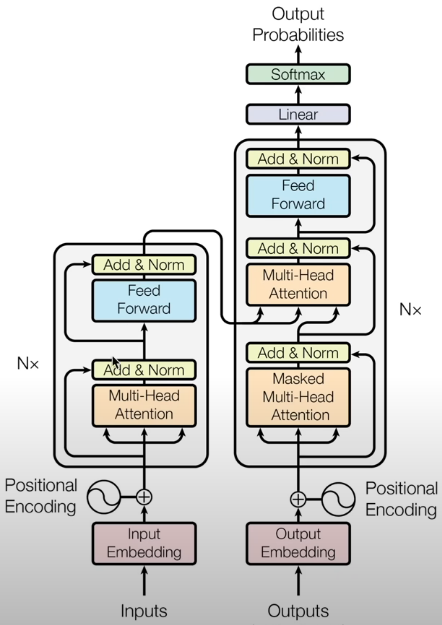

With the above, we implemented a **decoder-only transformer model**. It is a decoder, because we apply triangular masking to the attention matrix `wei`. The encoder part is missing.<br>
Our model only consists of the Self-Attention block and the Feed-Forward block. The 'encoder-fusing' cross-attention part is missing.<br>

We are just generating text based on an initial prompt, thus basically 'blabbering on' without further reference to anything.<br>
The original paper proposes an encoder-decoder architecture for machine translation: 
- The encoder part is a transformer model, too. It is trained to encode the source language into a fixed-size vector
- The decoder part is trained to decode the fixed-size vector into the target language
- Both encoder and decoder are trained to work together

| Encode | Decode |
| --- | --- |
| les chats sont mignons | <START>the cats are cute<END> |

Unlike what we did, the generation will be influenced by additional information, meaning the source language input.<br>
Within the encoder, **no** triangular masking is applied. The encoder is allowed to look at all the input tokens, time-wise.<br>
Feeding that into the decoder, the decoder is conditioned not only on the past of the current decoding, but also on the fully encoded input.<br>


### ChatGPT?!

How does ChatGPT relate to what we did here?<br>
To achieve a system like ChatGPT, two steps have to be taken: Pre-Training a Decoder-Only Transformer to 'babbel text' and then fine-tuning it on prompt-response pairs.<br>

With the context we now have, this should look familiar:<br>
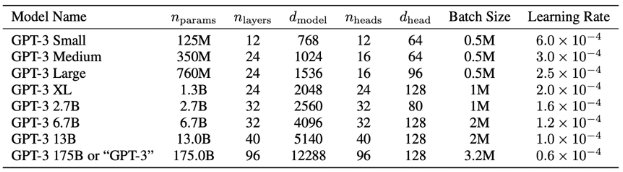

We have around $300,000$ tokens in our dataset. OpenAI has around $300,000,000,000$ tokens in their training dataset. And that is still small by today's (trillions) standards.<br>
**TL;DR:** OpenAI takes the transformer and blows it up to the max training- and finetuning-wise.<br>
The challenge OpenAI faces is thus not only one of building the AI, but maintaining an infrastructure that can handle the training and fine-tuning of such a model.

To now align the decoder-only 'babbeling' transformer with a task like chat generation, we need to add the encoder part and the cross-attention part.<br>
OpenAI does this like so:<br>
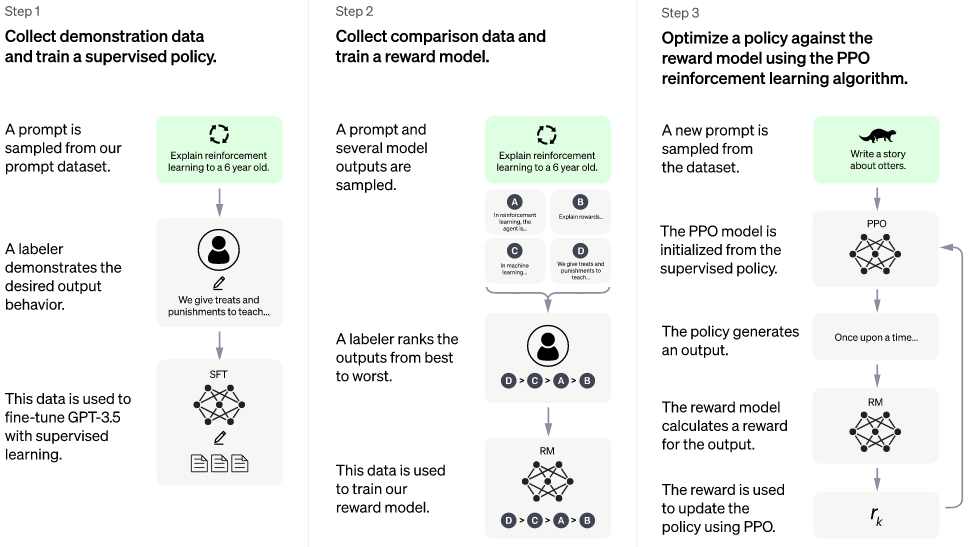

**Step 1:** Collect demonstration data and train a supervised policy
- Collect (a way smaller set of) training data for code generation (e.g. a question and the answer set on programming tasks)
- Fine-tune the model to focus on achieving a response that is as close as possible to the answer set. This aligns the model with the task of chat generation.

**Step 2:** Collect comparison data and train a reward model
- For one input, several iterations of outputs are collected and ranked by humans
- This information is used to train a reward model that can rank the outputs of the model by itself on a large scale

**Step 3:** Optimize a policy against the reward model using the [PPO](https://openai.com/blog/openai-baselines-ppo/) reinforcement learning algorithm
- Again, we start with a prompt from the training data
- Out trained (supervised policy) model takes the prompt and generates a response
    - [PPO](https://openai.com/blog/openai-baselines-ppo/) is applied so that the outputs that are ranked higher by the reward model are more likely to be generated

These steps take the model from being a 'blabby' decoder-only transformer to being a chat generator.